**Text fett markieren**# Challenge I - Facial Emotion Recognition (FER)
## Computer Vision meets Facial Expressions.

In this challenge it's all about detecting emotions in human faces (images). As demonstrated in the Computer Vision lecture, **convolutional neural networks** serve as an excellent tool to work with images. Thus, we expect you to engage with various CNNs, apply tools and concepts from the Computer Vision lectures, and evaluate various architectures to classify different facial expressions given images of human faces.

The data consists of 100x100 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of five categories (Angry, Fear, Happy, Sad, Surprise). The training set consists of 9,108 examples and the test set consists of 2,388 examples.

### Grading

We expect that you evaluate a bunch of different CNN archteicutres, starting from a simple CNN from scratch and ending with a pre-trained model. There are no limitations and you are encouraged to go even beyond the architectures presented in the lectures. Be as creative and try as many things as possible.

Please aware that it's not about making the best prediction. Rather we introduced the submissions as a funny way to engage coding with PyTorch.

Further, please try to code in an easy and understandable way, add comments, and documentation where necessary, as this **will** be part of your grading.

### Data

You will be given three files:

1. *train_images.tar.gz*: This zip file contains the training folder which is compromised of 5 subfolders, each representing a specific emotion including angry, fear, happy, sad, surprise. Each image within a subfolder is correspodning to that emotion.

2. *test_images.tar.gz*: This zip file contains a folder which comprises the 2,388 test images.

3. *submission.csv*: This csv file should serve as the final submission template. It simply contains the number of all test images. Please predict the emotion for each image and append another column which presents the emotion accordingly.

You can find the data [here](https://uni-koeln.sciebo.de/s/vPcXOe9uIyiuo2G).

1. Upload the data to you Google Colab Disk under */content/*
2. Use the code below to unzip *train_images.tar.gz* and *test_images.tar.gz*

In [ ]:
!tar zxvf /content/test_images.tar.gz
!tar zxvf /content/train_images.tar.gz

tar (child): /content/test_images.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
tar (child): /content/train_images.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


## Code

#### Data Loading

In order to use the data in CNNs, we need to extract the data from the uploaded folders, resize them and transform them to tensors. Furthermore, we split the data into train (50%), validation (approx. 30%) and test datasets (approx. 20%) and create the necessary dataloaders.

In [ ]:
import pandas as pd
import os
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Define paths to the extracted data
extracted_dir = "/content"
train_dir = os.path.join(extracted_dir, "train")
test_dir = os.path.join(extracted_dir, "test")

# Define transformations for data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess train data
dataset = ImageFolder(train_dir, transform=transform)

# Split the dataset into training and validation set
train_ratio = 0.63 # Results in 50 % split overall
val_ratio = 0.37 # Results in approx. 30 % split overall
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_ratio, val_ratio], generator=torch.Generator().manual_seed(42))

# Load and preprocess test data
test_dataset = ImageFolder(test_dir, transform=transform)

# Create dataloaders
batch_size = 32
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size)
num_classes = len(dataset.classes)

# Print information of the datasets
print("Dataset size:", len(dataset))
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))
print("Classes:", dataset.classes)
print("Number of Classes:", num_classes)

Dataset size: 9108
Train dataset size: 5739
Validation dataset size: 3369
Test dataset size: 2388
Classes: ['angry', 'fear', 'happy', 'sad', 'surprise']
Number of Classes: 5


#### Functions

In this part we define three fundamental functions, one function that calculates the accuracy, another that represents the training loop and a last one that plots the training and validation losses.

In [ ]:
# Accuracy function for model performance
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [ ]:
# Store the losses in lists for visualization
loss_train_list, loss_val_list = [],[]

# Training loop function
def train(model, train_dl, val_dl, epochs, optimizer, loss_func, device):

    # Clear loss lists
    loss_train_list.clear()
    loss_val_list.clear()

    # Print header
    print("epoch | train loss | train acc | val loss | val acc")

    # Training loop for each epoch
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        batches_train_acc = 0
        batches_train_loss = 0
        for images, labels in train_dl:
            optimizer.zero_grad()

            # Move data to the device (GPU if available)
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            pred = model(images)
            loss = loss_func(pred, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Compute training loss and accuracy
            batches_train_loss += loss.item()
            batches_train_acc += accuracy(pred, labels).item()

        # Compute avg training loss and accuracy
        batches_train_loss /= len(train_dl)
        batches_train_acc /= len(train_dl)

        # Validation
        model.eval()  # Set the model to evaluation mode
        batches_val_acc = 0
        batches_val_loss = 0
        with torch.no_grad():
            for images, labels in val_dl:

                # Move data to the device (GPU if available)
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                pred_val = model(images)
                loss_val = loss_func(pred_val, labels)

                # Compute validation loss and accuracy
                batches_val_loss += loss_val.item()
                batches_val_acc += accuracy(pred_val, labels).item()

        # Compute avg validation loss and accuracy
        batches_val_acc /= len(val_dl)
        batches_val_loss /= len(val_dl)

        # Append losses to the lists
        loss_train_list.append(batches_train_loss)
        loss_val_list.append(batches_val_loss)

        # Print the epoch's training and validation loss and accuracy
        print("---------------------------------------------------")
        print(f"  {epoch+1}   |    {batches_train_loss:.4f}  |  {batches_train_acc:.4f}   |  {batches_val_loss:.4f}  |   {batches_val_acc:.4f} ")

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation losses to evaluate the model
def plot_losses():
    fig, ax1 = plt.subplots()
    ax1.plot(loss_train_list, label="Training Loss")
    ax1.plot(loss_val_list, label="Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Average Loss")
    ax1.legend()
    fig.tight_layout()

#### Models

In [ ]:
# Assign device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Now we start with a very simple CNN architecture that consists of convolutional layers and two fully connected layers. Afterwards, we train this CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Simple CNN architecture
class SimpleCnn(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCnn, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling

        # Calculate the input size for the first fully connected layer
        fc1_input_size = 32 * 25 * 25  # Feature map size after convolutions and pooling

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.5864  |  0.2427   |  1.5815  |   0.2272 
---------------------------------------------------
  2   |    1.5607  |  0.2909   |  1.5324  |   0.3584 
---------------------------------------------------
  3   |    1.5163  |  0.3373   |  1.4886  |   0.3656 
---------------------------------------------------
  4   |    1.4660  |  0.3789   |  1.4307  |   0.4044 
---------------------------------------------------
  5   |    1.4193  |  0.4048   |  1.4107  |   0.4224 
---------------------------------------------------
  6   |    1.3787  |  0.4329   |  1.3743  |   0.4372 
---------------------------------------------------
  7   |    1.3462  |  0.4473   |  1.3770  |   0.4414 
---------------------------------------------------
  8   |    1.3286  |  0.4623   |  1.3496  |   0.4481 
---------------------------------------------------
  9   |    1.2991  |  0.4730   |  1.3558  |   0.

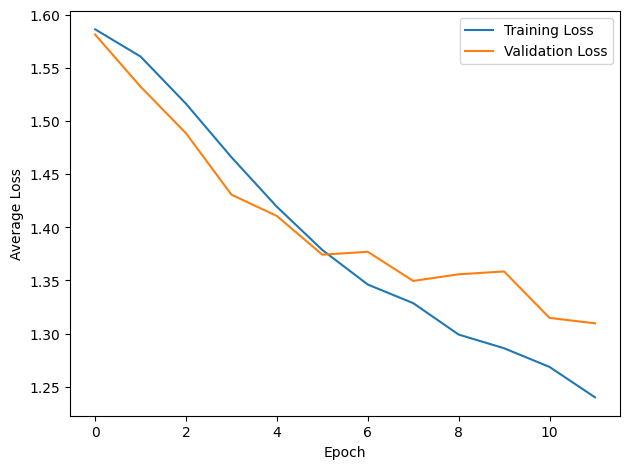

In [ ]:
from torch.optim import Adam

# Instantiate SimpleCNN model
model = SimpleCnn(num_classes)
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameters
epochs = 12
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

The next CNN architecture we try is very similar to the first one, except that we set the stride to 2 instead of 1.

In [ ]:
# Simple CNN architecture
class SimpleCnn2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCnn2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling

        # Calculate the input size for the first fully connected layer
        fc1_input_size = 32 * 6 * 6  # Feature map size after convolutions and pooling

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.5896  |  0.2333   |  1.5734  |   0.2853 
---------------------------------------------------
  2   |    1.5651  |  0.2830   |  1.5288  |   0.3017 
---------------------------------------------------
  3   |    1.4892  |  0.3519   |  1.4338  |   0.3919 
---------------------------------------------------
  4   |    1.4115  |  0.4072   |  1.4616  |   0.3953 
---------------------------------------------------
  5   |    1.3553  |  0.4326   |  1.3608  |   0.4327 
---------------------------------------------------
  6   |    1.3083  |  0.4603   |  1.3387  |   0.4492 
---------------------------------------------------
  7   |    1.2680  |  0.4845   |  1.2771  |   0.4759 
---------------------------------------------------
  8   |    1.2261  |  0.4996   |  1.3016  |   0.4598 
---------------------------------------------------
  9   |    1.1926  |  0.5229   |  1.2622  |   0.

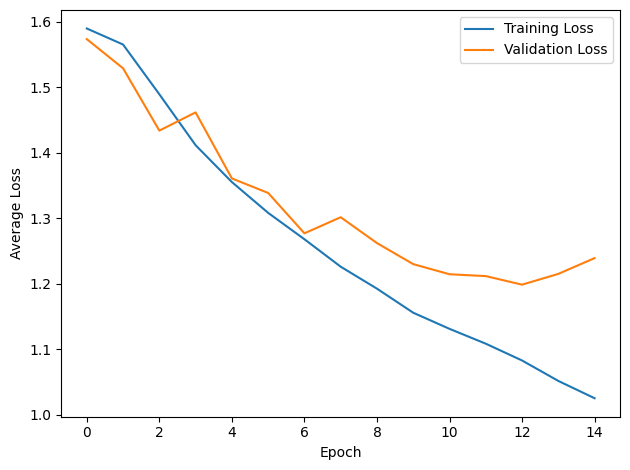

In [ ]:
# Instantiate SimpleCNN model
model = SimpleCnn2(num_classes)
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameters
epochs = 15
lr = 0.0005
optimizer = Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

For the next try, we create a CNN architecture that uses three convolutional layers and two fully connected layers. The stride is set to 1 again.

In [ ]:
# Simple CNN architecture
class SimpleCnn3(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCnn3, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling

        # Calculate the input size for the first fully connected layer
        fc1_input_size = 64 * 12 * 12  # Feature map size after convolutions and pooling

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.5823  |  0.2616   |  1.5435  |   0.3069 
---------------------------------------------------
  2   |    1.4717  |  0.3734   |  1.4159  |   0.3963 
---------------------------------------------------
  3   |    1.3274  |  0.4569   |  1.2721  |   0.4988 
---------------------------------------------------
  4   |    1.1714  |  0.5321   |  1.1682  |   0.5337 
---------------------------------------------------
  5   |    1.0456  |  0.5959   |  1.1149  |   0.5688 
---------------------------------------------------
  6   |    0.9516  |  0.6327   |  1.1072  |   0.5599 
---------------------------------------------------
  7   |    0.8567  |  0.6730   |  1.0744  |   0.5838 
---------------------------------------------------
  8   |    0.7677  |  0.7105   |  1.1313  |   0.5753 


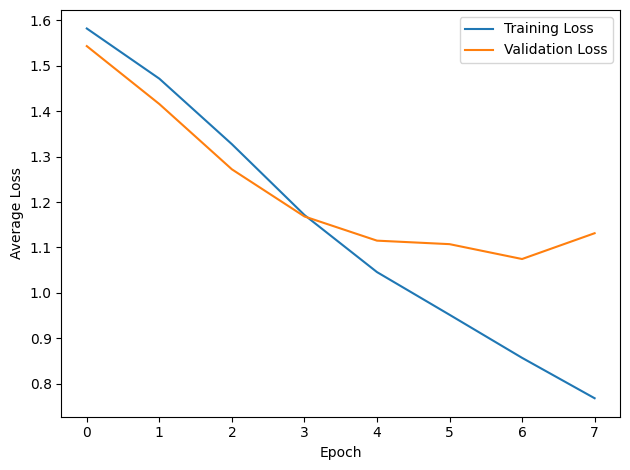

In [ ]:
# Instantiate SimpleCNN model
model = SimpleCnn3(num_classes)
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameters
epochs = 8
lr = 0.0005
optimizer = Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

As we observed with the second CNN architecture, the stride of 2 increased the performance so we try it again with the architecture before.

In [ ]:
# Simple CNN architecture
class SimpleCnn4(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCnn4, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the input size for the first fully connected layer
        fc1_input_size = 64  # Feature map size after convolutions and pooling

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.5914  |  0.2177   |  1.5816  |   0.2378 
---------------------------------------------------
  2   |    1.5867  |  0.2373   |  1.5810  |   0.2464 
---------------------------------------------------
  3   |    1.5801  |  0.2449   |  1.5692  |   0.2891 
---------------------------------------------------
  4   |    1.5641  |  0.2781   |  1.5438  |   0.2866 
---------------------------------------------------
  5   |    1.5439  |  0.2956   |  1.5352  |   0.3124 
---------------------------------------------------
  6   |    1.5118  |  0.3293   |  1.5114  |   0.3354 
---------------------------------------------------
  7   |    1.4735  |  0.3579   |  1.4656  |   0.3632 
---------------------------------------------------
  8   |    1.4332  |  0.3824   |  1.4469  |   0.3669 
---------------------------------------------------
  9   |    1.3951  |  0.4071   |  1.4123  |   0.

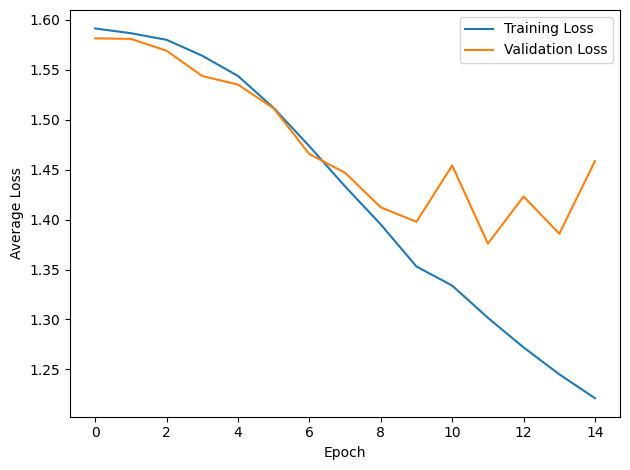

In [ ]:
# Instantiate SimpleCNN model
model = SimpleCnn4(num_classes)
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameters
epochs = 15
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

This time, the stride of 2 decreased the performance significantly.

Next we try a CNN architecture that adds a fourth convolutional layer. It still has two fully connected layers.

In [ ]:
# Simple CNN architecture
class SimpleCnn5(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCnn5, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling

        # Calculate the input size for the first fully connected layer
        fc1_input_size = 32 * 12 * 12  # Feature map size after convolutions and pooling

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.5928  |  0.2135   |  1.5821  |   0.2324 
---------------------------------------------------
  2   |    1.5654  |  0.2734   |  1.5548  |   0.2881 
---------------------------------------------------
  3   |    1.4471  |  0.3714   |  1.3633  |   0.4193 
---------------------------------------------------
  4   |    1.2930  |  0.4607   |  1.2628  |   0.4724 
---------------------------------------------------
  5   |    1.1721  |  0.5209   |  1.1850  |   0.5187 
---------------------------------------------------
  6   |    1.0768  |  0.5682   |  1.1079  |   0.5533 
---------------------------------------------------
  7   |    0.9933  |  0.6046   |  1.0973  |   0.5676 
---------------------------------------------------
  8   |    0.9235  |  0.6350   |  1.0999  |   0.5717 
---------------------------------------------------
  9   |    0.8602  |  0.6638   |  1.0608  |   0.

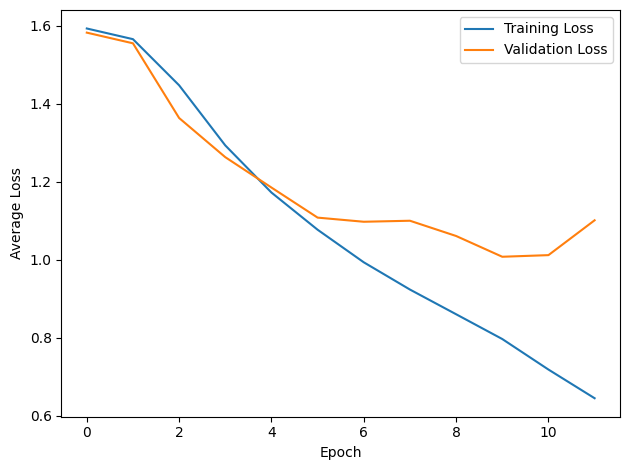

In [ ]:
# Instantiate SimpleCNN model
model = SimpleCnn5(num_classes)
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameters
epochs = 12
lr = 0.0005
optimizer = Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

This results in the best performance for now.

Now we want to try an architecture that uses max pooling only after the third and fourth convolutional layer.

In [ ]:
# Simple CNN architecture
class SimpleCnn6(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCnn6, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling

        # Calculate the input size for the first fully connected layer
        fc1_input_size = 128 * 25 * 25  # Feature map size after convolutions and pooling

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.5829  |  0.2494   |  1.5544  |   0.2881 
---------------------------------------------------
  2   |    1.5366  |  0.3223   |  1.4876  |   0.3434 
---------------------------------------------------
  3   |    1.4639  |  0.3713   |  1.4354  |   0.4088 
---------------------------------------------------
  4   |    1.4070  |  0.4086   |  1.3987  |   0.4280 
---------------------------------------------------
  5   |    1.3707  |  0.4309   |  1.3935  |   0.4244 
---------------------------------------------------
  6   |    1.3215  |  0.4603   |  1.3599  |   0.4535 
---------------------------------------------------
  7   |    1.2911  |  0.4744   |  1.3497  |   0.4603 
---------------------------------------------------
  8   |    1.2532  |  0.5010   |  1.3241  |   0.4708 
---------------------------------------------------
  9   |    1.2122  |  0.5162   |  1.3259  |   0.

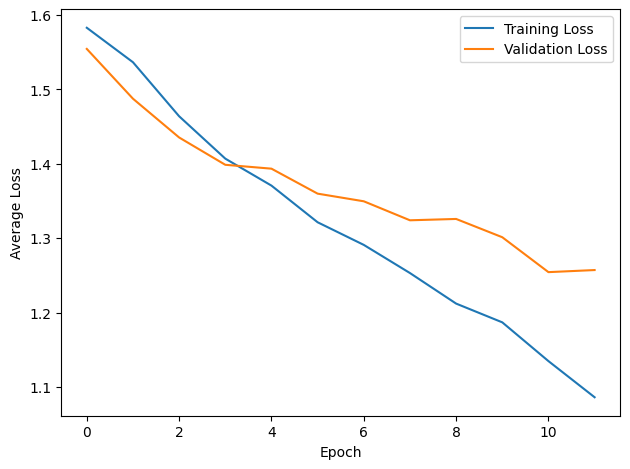

In [ ]:
# Instantiate SimpleCNN model
model = SimpleCnn6(num_classes)
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameters
epochs = 12
lr = 0.00005
optimizer = Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

This results in significantly lower performance as well, just like the stride adjustment did before.

For the next architecture we add a third fully connected layer and reversed the decision to adjust pooling.

In [ ]:
# Simple CNN architecture
class SimpleCnn7(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCnn7, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the input size for the first fully connected layer
        fc1_input_size = 32 * 12 * 12  # Feature map size after convolutions and pooling

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.5920  |  0.2180   |  1.5843  |   0.2271 
---------------------------------------------------
  2   |    1.5681  |  0.2755   |  1.5459  |   0.3203 
---------------------------------------------------
  3   |    1.4601  |  0.3706   |  1.3892  |   0.4262 
---------------------------------------------------
  4   |    1.2957  |  0.4601   |  1.2957  |   0.4647 
---------------------------------------------------
  5   |    1.1551  |  0.5298   |  1.2088  |   0.4996 
---------------------------------------------------
  6   |    1.0466  |  0.5857   |  1.1033  |   0.5656 
---------------------------------------------------
  7   |    0.9453  |  0.6232   |  1.0864  |   0.5650 
---------------------------------------------------
  8   |    0.8605  |  0.6685   |  1.0123  |   0.6042 
---------------------------------------------------
  9   |    0.7656  |  0.7094   |  1.0269  |   0.

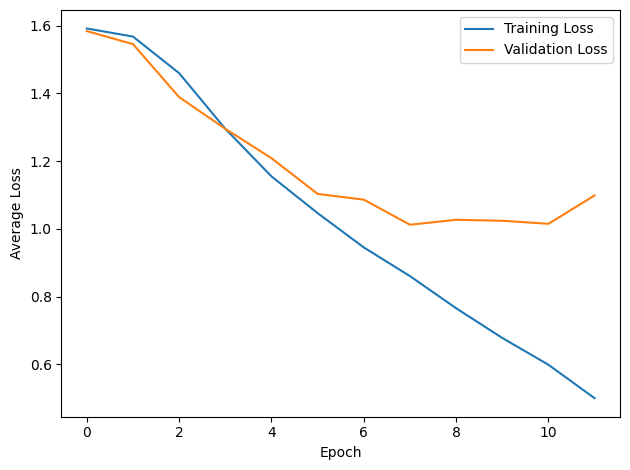

In [ ]:
# Instantiate SimpleCNN model
model = SimpleCnn7(num_classes)
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameters
epochs = 12
lr = 0.0005
optimizer = Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

The resulting performance is very similar to the performance of the fifth architecture.

For the last architecture we adjust numeber of nodes in the fully connected layers.

In [ ]:
# Simple CNN architecture
class SimpleCnn8(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCnn8, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the input size for the first fully connected layer
        fc1_input_size = 32 * 12 * 12  # Feature map size after convolutions and pooling

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.5914  |  0.2267   |  1.5751  |   0.2539 
---------------------------------------------------
  2   |    1.5319  |  0.3091   |  1.4414  |   0.3464 
---------------------------------------------------
  3   |    1.3570  |  0.4237   |  1.2958  |   0.4495 
---------------------------------------------------
  4   |    1.1986  |  0.5197   |  1.2053  |   0.5096 
---------------------------------------------------
  5   |    1.0638  |  0.5780   |  1.1124  |   0.5516 
---------------------------------------------------
  6   |    0.9521  |  0.6254   |  1.0711  |   0.5848 
---------------------------------------------------
  7   |    0.8158  |  0.6808   |  1.0872  |   0.5767 
---------------------------------------------------
  8   |    0.6864  |  0.7409   |  1.0143  |   0.6185 
---------------------------------------------------
  9   |    0.5354  |  0.8016   |  1.1831  |   0.

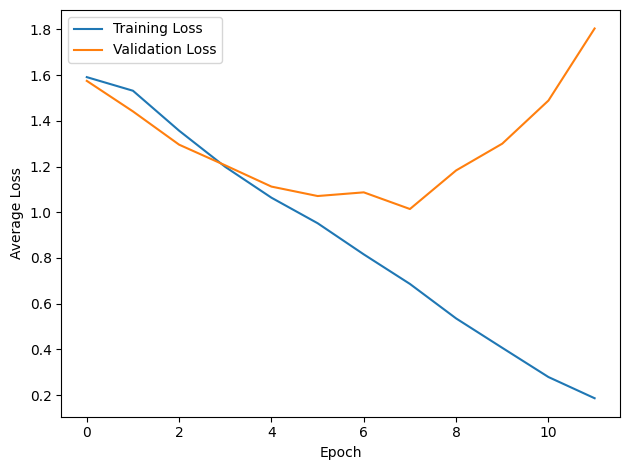

In [ ]:
# Instantiate SimpleCNN model
model = SimpleCnn8(num_classes)
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameters
epochs = 12
lr = 0.0005
optimizer = Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

The resulting performance is still very similar to the maximum performance we achieved before.

The last architecture we want to try is based on the AlexNet architecture.

In [ ]:
# CNN based on AlexNet architecture
class AlexNetFashionCNN(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetFashionCNN, self).__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(1024, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.5931  |  0.2199   |  1.5843  |   0.2200 
---------------------------------------------------
  2   |    1.5895  |  0.2182   |  1.5892  |   0.2198 
---------------------------------------------------
  3   |    1.5877  |  0.2234   |  1.5834  |   0.2505 
---------------------------------------------------
  4   |    1.5737  |  0.2540   |  1.5801  |   0.2497 
---------------------------------------------------
  5   |    1.5176  |  0.3137   |  1.4308  |   0.3891 
---------------------------------------------------
  6   |    1.3496  |  0.4173   |  1.2651  |   0.4609 
---------------------------------------------------
  7   |    1.1943  |  0.4921   |  1.2065  |   0.4945 
---------------------------------------------------
  8   |    1.0679  |  0.5518   |  1.1313  |   0.5450 
---------------------------------------------------
  9   |    0.9784  |  0.6037   |  1.1152  |   0.

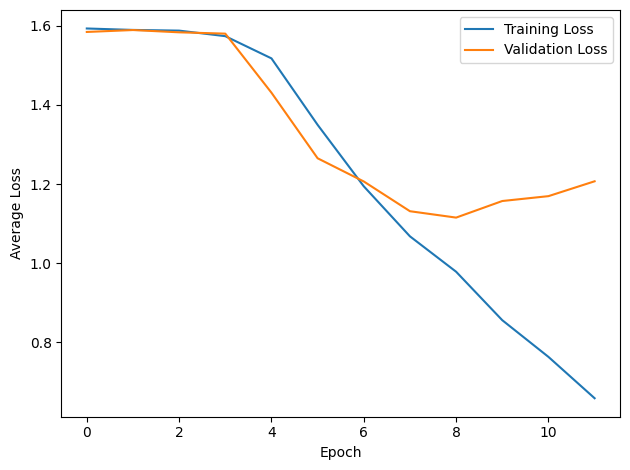

In [ ]:
# Instantiate AlexNetFashionCNN model
model = AlexNetFashionCNN(num_classes)
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameters
epochs = 12
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

We can observe that the performance of this model is still not better and the architecture itself is much more complex than the architectures we tried earlier.

Therfore, we will continue with pretrained ResNet18 models and compare their performance.

First, we want to try the ResNet18 model with the ResNet18 weights, another version with frozen weights (except for the classifier) and one model that includes dropout.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
# ResNet18 model
def resnet18_model():
    # Load pre-trained ResNet model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    # Modify the classifier to match the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.6MB/s]


epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.4556  |  0.3830   |  1.2632  |   0.4853 
---------------------------------------------------
  2   |    1.0788  |  0.5884   |  1.1064  |   0.5693 
---------------------------------------------------
  3   |    0.8497  |  0.6973   |  1.0135  |   0.6068 
---------------------------------------------------
  4   |    0.6928  |  0.7698   |  0.9602  |   0.6298 
---------------------------------------------------
  5   |    0.5469  |  0.8354   |  0.9285  |   0.6474 
---------------------------------------------------
  6   |    0.4225  |  0.8910   |  0.9095  |   0.6578 
---------------------------------------------------
  7   |    0.3245  |  0.9287   |  0.9037  |   0.6633 
---------------------------------------------------
  8   |    0.2445  |  0.9590   |  0.9048  |   0.6677 


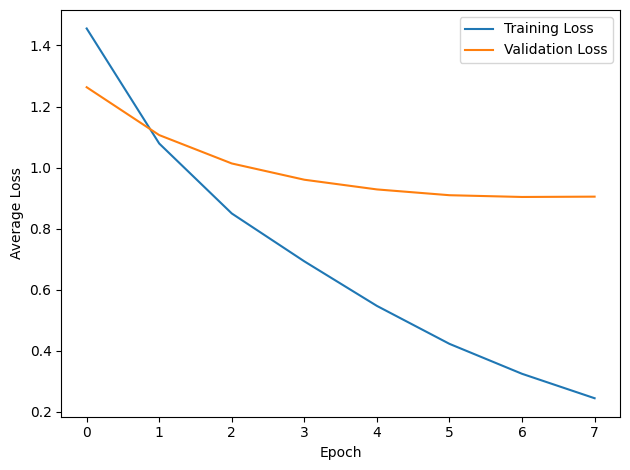

In [ ]:
# Instantiate ResNet18 model
model = resnet18_model()
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameters
epochs = 8
lr = 0.00001
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

In [ ]:
# ResNet18 model with frozen weights (except for classifier)
def resnet18_frozen_model():
    # Load pre-trained ResNet model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Freeze pre-trained layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify the classifier to match the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.6240  |  0.2651   |  1.5689  |   0.3043 
---------------------------------------------------
  2   |    1.5149  |  0.3382   |  1.4957  |   0.3563 
---------------------------------------------------
  3   |    1.4454  |  0.3907   |  1.4504  |   0.3837 
---------------------------------------------------
  4   |    1.4047  |  0.4110   |  1.4132  |   0.4069 
---------------------------------------------------
  5   |    1.3761  |  0.4303   |  1.3929  |   0.4208 
---------------------------------------------------
  6   |    1.3513  |  0.4437   |  1.3752  |   0.4336 
---------------------------------------------------
  7   |    1.3247  |  0.4614   |  1.3601  |   0.4435 
---------------------------------------------------
  8   |    1.3042  |  0.4718   |  1.3503  |   0.4478 
---------------------------------------------------
  9   |    1.3010  |  0.4734   |  1.3364  |   0.

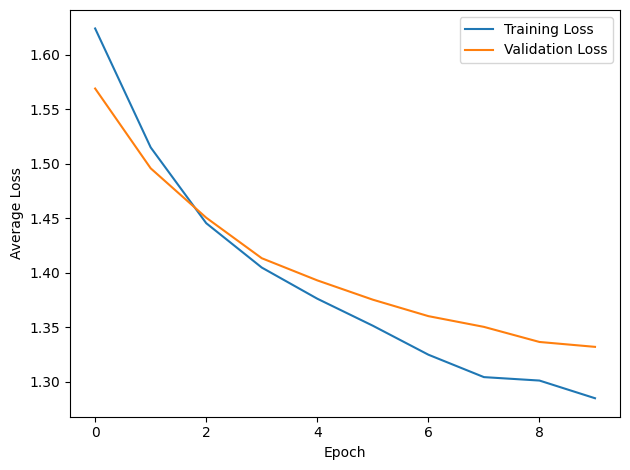

In [ ]:
# Instantiate model
model = resnet18_frozen_model()
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameter
epochs = 10
lr = 0.0001
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# Call the training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

In [ ]:
# Model with dropout
def resnet18_dropout_model():
    # Load pre-trained ResNet model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    # Modify last fully connected layer
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    return model

epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.1694  |  0.5262   |  0.8467  |   0.6779 
---------------------------------------------------
  2   |    0.6485  |  0.7614   |  0.7841  |   0.7159 
---------------------------------------------------
  3   |    0.3405  |  0.8851   |  0.8231  |   0.7317 
---------------------------------------------------
  4   |    0.1758  |  0.9424   |  0.9547  |   0.7262 
---------------------------------------------------
  5   |    0.1410  |  0.9539   |  1.0232  |   0.7222 


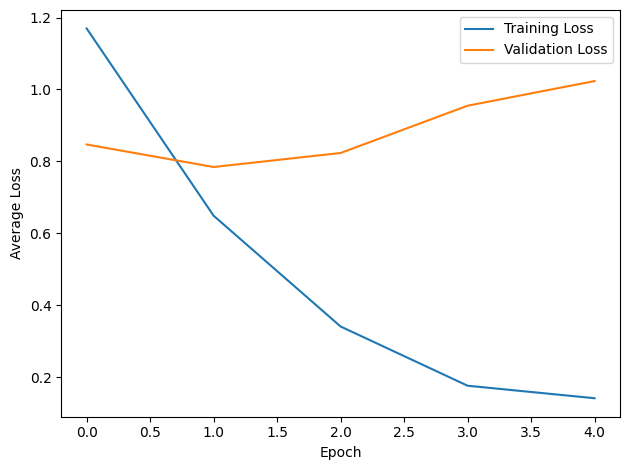

In [ ]:
# Instantiate model
model = resnet18_dropout_model()
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameter
epochs = 5
lr = 0.0001
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

The ResNet18 model with dropout performed the best and the model with frozen weights resulted in the lowest performance of all three.

Lastly, we try out the pretrained DenseNet121 model and an extended version with dropout and compare their performance.

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights
# ResNet50 model
def densenet121_model():
    # Load pre-trained ResNet model
    model = densenet121(weights=DenseNet121_Weights.DEFAULT)
    # Modify the classifier to match the number of classes
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 76.5MB/s]


epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.1530  |  0.5374   |  0.8675  |   0.6668 
---------------------------------------------------
  2   |    0.5772  |  0.7943   |  0.7589  |   0.7192 
---------------------------------------------------
  3   |    0.2661  |  0.9224   |  0.7711  |   0.7354 
---------------------------------------------------
  4   |    0.1146  |  0.9731   |  0.8472  |   0.7351 
---------------------------------------------------
  5   |    0.0740  |  0.9818   |  0.8393  |   0.7426 
---------------------------------------------------
  6   |    0.0589  |  0.9853   |  0.9490  |   0.7134 


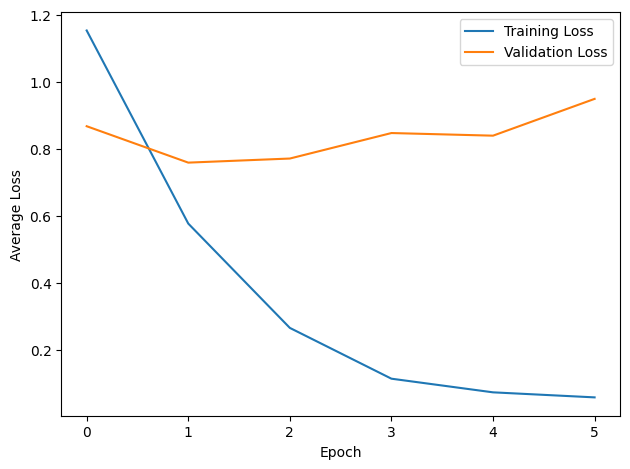

In [ ]:
# Instantiate model
model = densenet121_model()
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameter
epochs = 6
lr = 0.0001
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

In [ ]:
# DenseNet50 model with extended classifier and dropout
def densenet121_extended_model():
    # Load pre-trained ResNet model
    model = densenet121(weights=DenseNet121_Weights.DEFAULT)
    # Modify the classifier to match the number of classes
    model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_classes)
    )
    return model

epoch | train loss | train acc | val loss | val acc
---------------------------------------------------
  1   |    1.3981  |  0.4112   |  0.9682  |   0.6146 
---------------------------------------------------
  2   |    0.8440  |  0.6851   |  0.7687  |   0.7168 
---------------------------------------------------
  3   |    0.4829  |  0.8299   |  0.7345  |   0.7426 
---------------------------------------------------
  4   |    0.2926  |  0.9049   |  0.7473  |   0.7645 
---------------------------------------------------
  5   |    0.1899  |  0.9389   |  0.8417  |   0.7563 
---------------------------------------------------
  6   |    0.1402  |  0.9563   |  0.9135  |   0.7696 
---------------------------------------------------
  7   |    0.1030  |  0.9686   |  0.9714  |   0.7608 
---------------------------------------------------
  8   |    0.0861  |  0.9712   |  0.9772  |   0.7632 


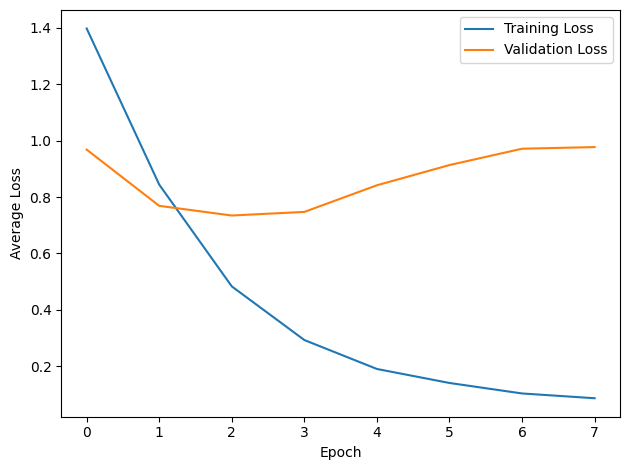

In [ ]:
# Instantiate model
model = densenet121_extended_model()
# Move the model to device (GPU if available)
model.to(device)

# Hyperparameter
epochs = 8
lr = 0.0001
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# Call training function
train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)
plot_losses()

We can observe that the performance of the DenseNet121 models are very similar. We chose the extended version for the final test set prediction.

### Training the final model

For the final model training we use the optimal hyperparameters that we determined. We use only 4 epochs for better generalization of the model. We also want to train the model on all available labeled data (train + validation), which is why we have to define a new training loop.

In [ ]:
# Instantiate model
final_model = densenet121_extended_model()
# Move the model to device (GPU if available)
final_model.to(device)

# Hyperparameter
epochs = 4
lr = 0.0001
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(final_model.parameters(), lr=lr)

In [ ]:
# Print header
print("epoch | train loss | train acc")

# Training loop for each epoch
for epoch in range(epochs):
    final_model.train()  # Set the model to training mode
    batches_train_acc = 0
    batches_train_loss = 0
    for images, labels in train_dl:
        optimizer.zero_grad()

        # Move data to the device (GPU if available)
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        pred = final_model(images)
        loss = loss_func(pred, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute training loss and accuracy
        batches_train_loss += loss.item()
        batches_train_acc += accuracy(pred, labels).item()

    # Compute avg training loss and accuracy
    batches_train_loss /= len(train_dl)
    batches_train_acc /= len(train_dl)

    # Print the epoch's training loss and accuracy
    print("-------------------------------")
    print(f"  {epoch+1}   |    {batches_train_loss:.4f}  |  {batches_train_acc:.4f}")

epoch | train loss | train acc
-------------------------------
  1   |    1.3833  |  0.4122
-------------------------------
  2   |    0.8437  |  0.6814
-------------------------------
  3   |    0.5264  |  0.8208
-------------------------------
  4   |    0.3115  |  0.8948


## Final Submission

In [ ]:
submission_df = pd.read_csv('/content/submission.csv')

In [ ]:
submission_df.head()

,file
0,fb5a70aceb5f.jpg
1,54e0af65c9e0.jpg
2,0c4bfd397359.jpg
3,722800dabb11.jpg
4,6f2308ab2165.jpg


In [ ]:
# Add your predictions here. This is just an example and it will result in predicting 'fear' for each image (probably not a good idea)

# Set the model to evaluation mode
final_model.eval()

# Store predicted emotions in list
predicted_emotions = []

with torch.no_grad():
    for images, _ in test_dl:
        # Move data to the device (GPU if available)
        images = images.to(device)
        # Make prediction
        outputs = final_model(images)
        # Get the predicted labels
        _, predicted = torch.max(outputs, 1)
        # Add predicted labels to list
        predicted_emotions.extend(predicted.tolist())

# Create a list of the filenames (which is in the same order as test_dl)
test_filenames = [os.path.basename(file) for file, _ in test_dataset.imgs]

# Create a mapping of filenames to predicted emotions
filename_to_emotion = {filename: dataset.classes[emotion] for filename, emotion in zip(test_filenames, predicted_emotions)}

# Add predicted emotions to submission_df using the mapping
submission_df['emotions'] = submission_df['file'].map(filename_to_emotion)

In [ ]:
submission_df.head()

,file,emotions
0,fb5a70aceb5f.jpg,fear
1,54e0af65c9e0.jpg,fear
2,0c4bfd397359.jpg,sad
3,722800dabb11.jpg,fear
4,6f2308ab2165.jpg,sad


In [ ]:
# This will create your submission file which you should hand in.
submission_df.to_csv("/content/submission_solution.csv", index=False)

Done